In [1]:
##https://www.statology.org/matplotlib-rectangle/
from PIL import Image
from io import BytesIO
import numpy as np
import matplotlib.pyplot as plt
import girder_client
import dsaSecrets 
import random
from matplotlib.patches import Rectangle
from IPython.display import display
import matplotlib.pylab as plt
import numpy as np
from ipywidgets import interact,FloatSlider,IntSlider,interactive,HBox,VBox, fixed, Button
%matplotlib inline

%load_ext autoreload
%autoreload 2
import tmaHelpers as tma

gc = girder_client.GirderClient(apiUrl=dsaSecrets.apiUrl)
gc.authenticate(apiKey=dsaSecrets.apiToken)
## Samples Images 62bb03e4e70def4ae72689f5

%matplotlib inline

In [2]:
## SEt all the variables needed to pull an image, as well as the fiducial points.. for now the fiducials are at 0.625X
studyImageId = '62ded6cbe70def4ae726b228'
studyImages = list(gc.listItem(studyImageId))
imgId = '62bb03e4e70def4ae72689f5'
dispMag = 0.625 ### For testing I don't want to try and view the entire 20 or 40X image..

imgId='62ded6e6e70def4ae726b3fd'

imgId = '62ded6e7e70def4ae726b41b'

#add rectangle
topLeft = (115,50)
bottomRight = (1540,1180)
topRight = (1560,70)

colLabels = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]
rowLabels = ["A","B","C","D","E","F","G","H","I","J"]

tileInfo = gc.get('item/%s/tiles' % imgId)
#https://styx.neurology.emory.edu/girder/api/v1/item/62bb03e4e70def4ae72689f5/tiles/region?units=base_pixels&magnification=0.625&exact=false&encoding=JPEG&jpegQuality=95&jpegSubsampling=0
imgThumb = gc.get("item/%s/tiles/region?units=base_pixel&magnification=%s" % (imgId, dispMag),jsonResp=False)

In [6]:
import ipywidgets as widgets
from IPython.display import display

from IPython.display import clear_output

# ## Convert image to a numpy array so I can plot it with matplotlib
region_im = np.array(Image.open(BytesIO(imgThumb.content)))
tmaCore = region_im 
### can use the region_im.shape to set sensible defaults for the tmaWidth and Height
tmaWidth_s,tmaHeight_s, theta_s,leftX_s,leftY_s = tma.generateTMAcontrols(rowLabels,colLabels, region_im)

annotationElements = []

ip = interactive(tma.plotGrid,w=tmaWidth_s,h=tmaHeight_s,x1=leftX_s,y1=leftY_s,theta=theta_s,
                 baseImage=fixed(region_im),colLabels=fixed(colLabels),rowLabels=fixed(rowLabels),annotationElements=fixed(annotationElements))

ctrlLineOne = HBox([tmaWidth_s,tmaHeight_s,theta_s])
ctrlLineTwo = HBox([leftX_s,leftY_s])

display(VBox([ctrlLineOne,ctrlLineTwo ]))#Show all controls

display(ip.children[-1])#Show the output
#display(ip)#Show the output

button = widgets.Button(description="TMA Updated")
output = widgets.Output()

display(button, output)

button.on_click(on_button_clicked)
#97, 113, -2.60


Output()

Button(description='TMA Updated', style=ButtonStyle())

Output()

In [5]:
def on_button_clicked(b):
#     global ticker
#     ticker = myfunc(w.value)
    with output:
        clear_output()
        print('UPDATING TMA OUTPUT' )
        tma.updateAutoTMA(imgId,annotationElements,gc)

In [28]:
annotationElements

[]

### Rotating a grid...  need to also deal with offset..
X=xcos(θ)+ysin(θ)
Y=−x*sin(θ)+y*cos(θ)


In [47]:
import os

def export_tma_cores( gc, imgId, tmaAnnotationName='autoTMA'):
    ### This will save cropped regions from the itemID... will pass it the annotation ID as well
    i = gc.get('item/%s' % imgId)
    
    fileRoot = i['meta']['slideNumber']
    
    ## Get autoTMA documents for this item
    tmaDocs=  gc.get('annotation?itemId=%s&name=%s' % (imgId, tmaAnnotationName))
    print(len(tmaDocs),'autoTMA annotations found... will use the most recent one')
    
    ae = gc.get('annotation/%s' % tmaDocs[-1]['_id']) ## Grab the last one... assume that's the most recent.. may need to check
    
    print(len(ae['annotation']['elements']),'total ROIs to export')
    
    roiDir = 'ROI_Export'
    
    if not os.path.isdir(roiDir):
        os.mkdir(roiDir)

    for roi in ae['annotation']['elements']:
        roiFileName = "%s/%s.%s.%d.%d.tiff" % (roiDir,fileRoot,roi['label']['value'],roi['center'][0],roi['center'][1])
        
        if not os.path.isfile(roiFileName):
            print(roiFileName)
            r= tma.get_annotation_region(gc,imgId,roi)        

            with open(roiFileName,"wb") as fpi:
                fpi.write(r)
        
        
    #print(i,fileRoot)
export_tma_cores(gc,'62ded6e7e70def4ae726b41b')


1 autoTMA annotations found... will use the most recent one
150 total ROIs to export
ROI_Export/S17.A1.2528.2672.tiff
{'fillColor': 'rgba(0, 0, 0, 0)', 'label': {'value': 'A1'}, 'lineColor': 'rgba(255,0,0,1)', 'lineWidth': 1, 'type': 'rectangle', 'center': [2528.0, 2672.0, 0], 'width': 3136, 'height': 3680, 'id': '62defe92e70def4ae726c89f'}
62ded6e7e70def4ae726b41b/tiles/region?left=960.0&top=832.0&right=4096.0&bottom=4512.0&units=base_pixels&exact=false&encoding=TILED&jpegQuality=100&jpegSubsampling=0
ROI_Export/S17.B1.2579.6351.tiff
{'fillColor': 'rgba(0, 0, 0, 0)', 'label': {'value': 'B1'}, 'lineColor': 'rgba(255,10,0,1)', 'lineWidth': 1, 'type': 'rectangle', 'center': [2579.3808236480545, 6351.64128835424, 0], 'width': 3136, 'height': 3680, 'id': '62defe92e70def4ae726c8a0'}
62ded6e7e70def4ae726b41b/tiles/region?left=1011.3808236480545&top=4511.64128835424&right=4147.3808236480545&bottom=8191.64128835424&units=base_pixels&exact=false&encoding=TILED&jpegQuality=100&jpegSubsampling=0


ROI_Export/S17.H2.6023.28385.tiff
{'fillColor': 'rgba(0, 0, 0, 0)', 'label': {'value': 'H2'}, 'lineColor': 'rgba(255,222,0,1)', 'lineWidth': 1, 'type': 'rectangle', 'center': [6023.3600808295605, 28385.703620936118, 0], 'width': 3136, 'height': 3680, 'id': '62defe92e70def4ae726c8b0'}
62ded6e7e70def4ae726b41b/tiles/region?left=4455.3600808295605&top=26545.703620936118&right=7591.3600808295605&bottom=30225.703620936118&units=base_pixels&exact=false&encoding=TILED&jpegQuality=100&jpegSubsampling=0
ROI_Export/S17.I2.6074.32065.tiff
{'fillColor': 'rgba(0, 0, 0, 0)', 'label': {'value': 'I2'}, 'lineColor': 'rgba(255,232,0,1)', 'lineWidth': 1, 'type': 'rectangle', 'center': [6074.740904477615, 32065.344909290357, 0], 'width': 3136, 'height': 3680, 'id': '62defe92e70def4ae726c8b1'}
62ded6e7e70def4ae726b41b/tiles/region?left=4506.740904477615&top=30225.344909290357&right=7642.740904477615&bottom=33905.34490929036&units=base_pixels&exact=false&encoding=TILED&jpegQuality=100&jpegSubsampling=0
ROI_

ROI_Export/S17.E4.12140.17259.tiff
{'fillColor': 'rgba(0, 0, 0, 0)', 'label': {'value': 'E4'}, 'lineColor': 'rgba(14,255,0,1)', 'lineWidth': 1, 'type': 'rectangle', 'center': [12140.606240471752, 17259.20896078628, 0], 'width': 3136, 'height': 3680, 'id': '62defe92e70def4ae726c8c1'}
62ded6e7e70def4ae726b41b/tiles/region?left=10572.606240471752&top=15419.20896078628&right=13708.606240471752&bottom=19099.20896078628&units=base_pixels&exact=false&encoding=TILED&jpegQuality=100&jpegSubsampling=0
ROI_Export/S17.F4.12191.20938.tiff
{'fillColor': 'rgba(0, 0, 0, 0)', 'label': {'value': 'F4'}, 'lineColor': 'rgba(6,255,2,1)', 'lineWidth': 1, 'type': 'rectangle', 'center': [12191.987064119807, 20938.85024914052, 0], 'width': 3136, 'height': 3680, 'id': '62defe92e70def4ae726c8c2'}
62ded6e7e70def4ae726b41b/tiles/region?left=10623.987064119807&top=19098.85024914052&right=13759.987064119807&bottom=22778.85024914052&units=base_pixels&exact=false&encoding=TILED&jpegQuality=100&jpegSubsampling=0
ROI_Exp

ROI_Export/S17.B6.18257.6132.tiff
{'fillColor': 'rgba(0, 0, 0, 0)', 'label': {'value': 'B6'}, 'lineColor': 'rgba(0,251,255,1)', 'lineWidth': 1, 'type': 'rectangle', 'center': [18257.852400113945, 6132.714300636442, 0], 'width': 3136, 'height': 3680, 'id': '62defe92e70def4ae726c8d2'}
62ded6e7e70def4ae726b41b/tiles/region?left=16689.852400113945&top=4292.714300636442&right=19825.852400113945&bottom=7972.714300636442&units=base_pixels&exact=false&encoding=TILED&jpegQuality=100&jpegSubsampling=0
ROI_Export/S17.C6.18309.9812.tiff
{'fillColor': 'rgba(0, 0, 0, 0)', 'label': {'value': 'C6'}, 'lineColor': 'rgba(0,241,255,1)', 'lineWidth': 1, 'type': 'rectangle', 'center': [18309.233223762, 9812.355588990682, 0], 'width': 3136, 'height': 3680, 'id': '62defe92e70def4ae726c8d3'}
62ded6e7e70def4ae726b41b/tiles/region?left=16741.233223762&top=7972.355588990682&right=19877.233223762&bottom=11652.355588990682&units=base_pixels&exact=false&encoding=TILED&jpegQuality=100&jpegSubsampling=0
ROI_Export/S17

ROI_Export/S17.I7.21753.31846.tiff
{'fillColor': 'rgba(0, 0, 0, 0)', 'label': {'value': 'I7'}, 'lineColor': 'rgba(0,29,255,1)', 'lineWidth': 1, 'type': 'rectangle', 'center': [21753.212480943504, 31846.41792157256, 0], 'width': 3136, 'height': 3680, 'id': '62defe92e70def4ae726c8e3'}
62ded6e7e70def4ae726b41b/tiles/region?left=20185.212480943504&top=30006.41792157256&right=23321.212480943504&bottom=33686.41792157256&units=base_pixels&exact=false&encoding=TILED&jpegQuality=100&jpegSubsampling=0
ROI_Export/S17.J7.21804.35526.tiff
{'fillColor': 'rgba(0, 0, 0, 0)', 'label': {'value': 'J7'}, 'lineColor': 'rgba(0,19,255,1)', 'lineWidth': 1, 'type': 'rectangle', 'center': [21804.59330459156, 35526.059209926796, 0], 'width': 3136, 'height': 3680, 'id': '62defe92e70def4ae726c8e4'}
62ded6e7e70def4ae726b41b/tiles/region?left=20236.59330459156&top=33686.059209926796&right=23372.59330459156&bottom=37366.059209926796&units=base_pixels&exact=false&encoding=TILED&jpegQuality=100&jpegSubsampling=0
ROI_Ex

ROI_Export/S17.F9.27870.20719.tiff
{'fillColor': 'rgba(0, 0, 0, 0)', 'label': {'value': 'F9'}, 'lineColor': 'rgba(243,0,255,1)', 'lineWidth': 1, 'type': 'rectangle', 'center': [27870.458640585697, 20719.923261422722, 0], 'width': 3136, 'height': 3680, 'id': '62defe92e70def4ae726c8f4'}
62ded6e7e70def4ae726b41b/tiles/region?left=26302.458640585697&top=18879.923261422722&right=29438.458640585697&bottom=22559.923261422722&units=base_pixels&exact=false&encoding=TILED&jpegQuality=100&jpegSubsampling=0
ROI_Export/S17.G9.27921.24399.tiff
{'fillColor': 'rgba(0, 0, 0, 0)', 'label': {'value': 'G9'}, 'lineColor': 'rgba(249,0,250,1)', 'lineWidth': 1, 'type': 'rectangle', 'center': [27921.83946423375, 24399.564549776962, 0], 'width': 3136, 'height': 3680, 'id': '62defe92e70def4ae726c8f5'}
62ded6e7e70def4ae726b41b/tiles/region?left=26353.83946423375&top=22559.564549776962&right=29489.83946423375&bottom=26239.564549776962&units=base_pixels&exact=false&encoding=TILED&jpegQuality=100&jpegSubsampling=0
R

ROI_Export/S17.C11.33987.9593.tiff
{'fillColor': 'rgba(0, 0, 0, 0)', 'label': {'value': 'C11'}, 'lineColor': 'rgba(255,0,23,1)', 'lineWidth': 1, 'type': 'rectangle', 'center': [33987.70480022789, 9593.428601272884, 0], 'width': 3136, 'height': 3680, 'id': '62defe92e70def4ae726c905'}
62ded6e7e70def4ae726b41b/tiles/region?left=32419.70480022789&top=7753.428601272884&right=35555.70480022789&bottom=11433.428601272884&units=base_pixels&exact=false&encoding=TILED&jpegQuality=100&jpegSubsampling=0
ROI_Export/S17.D11.34039.13273.tiff
{'fillColor': 'rgba(0, 0, 0, 0)', 'label': {'value': 'D11'}, 'lineColor': 'rgba(255,0,23,1)', 'lineWidth': 1, 'type': 'rectangle', 'center': [34039.085623875944, 13273.069889627124, 0], 'width': 3136, 'height': 3680, 'id': '62defe92e70def4ae726c906'}
62ded6e7e70def4ae726b41b/tiles/region?left=32471.085623875944&top=11433.069889627124&right=35607.085623875944&bottom=15113.069889627124&units=base_pixels&exact=false&encoding=TILED&jpegQuality=100&jpegSubsampling=0
RO

ROI_Export/S17.J12.37483.35307.tiff
{'fillColor': 'rgba(0, 0, 0, 0)', 'label': {'value': 'J12'}, 'lineColor': 'rgba(255,0,23,1)', 'lineWidth': 1, 'type': 'rectangle', 'center': [37483.06488105745, 35307.132222209, 0], 'width': 3136, 'height': 3680, 'id': '62defe92e70def4ae726c916'}
62ded6e7e70def4ae726b41b/tiles/region?left=35915.06488105745&top=33467.132222209&right=39051.06488105745&bottom=37147.132222209&units=base_pixels&exact=false&encoding=TILED&jpegQuality=100&jpegSubsampling=0
ROI_Export/S17.A13.40156.2146.tiff
{'fillColor': 'rgba(0, 0, 0, 0)', 'label': {'value': 'A13'}, 'lineColor': 'rgba(255,0,23,1)', 'lineWidth': 1, 'type': 'rectangle', 'center': [40156.33178351814, 2146.575229477285, 0], 'width': 3136, 'height': 3680, 'id': '62defe92e70def4ae726c917'}
62ded6e7e70def4ae726b41b/tiles/region?left=38588.33178351814&top=306.5752294772851&right=41724.33178351814&bottom=3986.575229477285&units=base_pixels&exact=false&encoding=TILED&jpegQuality=100&jpegSubsampling=0
ROI_Export/S17.

KeyboardInterrupt: 

3 autoTMA annotations found... will use the most recent one
150 total ROIs to export


In [ ]:
tmaCore = region_im[ys:ye,xs:xe,:]

img=np.copy(tmaCore)
#ret,th2 = cv2.threshold(~img,20,255,cv2.THRESH_BINARY)

gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
blurred = cv2.GaussianBlur(gray, (7, 7), 0)

ret = [0,0,0,0]  ## intialize array with 4 values

ret[1],th1 = cv2.threshold(~gray,127,255,cv2.THRESH_BINARY)
(ret[2], th2) = cv2.threshold(blurred, 0, 255,cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)
ret[3],th3 = cv2.threshold(~img,30,255,cv2.THRESH_BINARY)

### OTSU THRESHOLIND ON BLURRED IMAGE WORKED THE BEST



titles = ['Original Image ', 'Global Thresholding (v = 10) ',
            'Otsu Thresholding ', 'Adaptive Gaussian Thresholding ']
images = [img, th1, th2, th3]
for i in range(4):
    plt.subplot(2,2,i+1),plt.imshow(images[i],'gray')
    plt.title(titles[i]+str(ret[i]))
    plt.xticks([]),plt.yticks([])
    
    ## Computing Centroid of images as well... will eventually do something with this..
    cX,cY = tma.calculateImgCentroid(images[i],ret[i])
    print('Centroid of image %d is %s %s' % (i,cX,cY))
    
plt.show()

In [ ]:



# plt.rcParams["figure.figsize"] = (15,15)
# plt.imshow(region_im)

# tmaWidth = ( bottomRight[0] - topLeft[0] ) / len(colLabels)
# tmaHeight = ( bottomRight[1] - topLeft[1] ) / len(rowLabels)
# elementScaleFactor = tileInfo['magnification']/dispMag

# cmap = tma.get_cmap( len(colLabels) * len(rowLabels))

# ## While I display the ROI in a matplotlib figure below
# annotationElements = []

# for x,r in enumerate(colLabels):
#     #print("Row: %s" % r)
#     for y,c in enumerate(rowLabels):
#         #print("\t",r,c)

#         x1 = tmaWidth*x+topLeft[0]
#         y1 = tmaHeight*y+topLeft[1]
        
#         plt.gca().add_patch(Rectangle((x1,y1),tmaWidth,tmaHeight,
#                             angle=1,
#                             edgecolor=cmap( random.randint(0,len(colLabels) * len(rowLabels))),
#                             facecolor='none',
#                             lw=2))
        
#         annotationElements.append( {'fillColor': 'rgba(0, 0, 0, 0)',
#     'label': {"value": "%s%s" % (r,c)},
#     'lineColor': tma.generate_random_color(),
#     'lineWidth': 1,
#     'type': 'rectangle',
#     'center': [(x1+tmaWidth/2)*elementScaleFactor,(y1+tmaHeight/2)*elementScaleFactor,0],
#     'width': tmaWidth*elementScaleFactor,
#     'height': tmaHeight*elementScaleFactor,
#     })
        
# #plot fiducial for upper left 
# plt.plot(topLeft[0],topLeft[1], marker='v', color="red")
# #plot fiducial for bottom right
# plt.plot(bottomRight[0],bottomRight[1], marker='x', color="blue")

# #add fiducial for topRight
# plt.plot(topRight[0],topRight[1], marker='o', color="pink")

# tmaAe = {
#   "name": "autoTMA",              # Non-empty string.  Optional
#   "description": "This is a description",  # String.  Optional
#   "elements": annotationElements                           # A list.  Optional.
#                                            # See below for valid elements.
# }
# gc.post('annotation?itemId=%s' % imgId,json=tmaAe)


In [ ]:
# th2 = cv2.adaptiveThreshold(img,255,cv2.ADAPTIVE_THRESH_MEAN_C,\
#             cv2.THRESH_BINARY,11,2)
# th3 = cv2.adaptiveThreshold(img,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,\
#             cv2.THRESH_BINARY,11,2)
# convert the image to grayscale and blur it slightly
# gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
# blurred = cv2.GaussianBlur(gray, (7, 7), 0)

# plt.imshow(region_im)


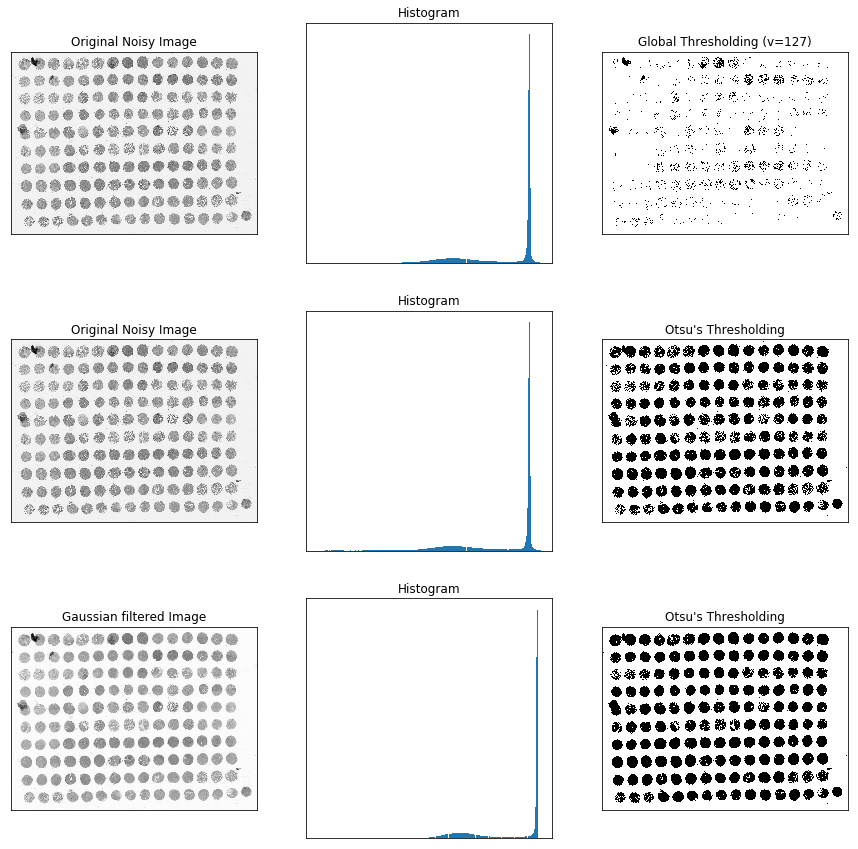

In [49]:
import cv2 as cv
import cv2
import numpy as np
from matplotlib import pyplot as plt

img = cv2.cvtColor(tmaCore, cv2.COLOR_BGR2GRAY)


# global thresholding
ret1,th1 = cv.threshold(img,127,255,cv.THRESH_BINARY)
# Otsu's thresholding
ret2,th2 = cv.threshold(img,0,255,cv.THRESH_BINARY+cv.THRESH_OTSU)
# Otsu's thresholding after Gaussian filtering
blur = cv.GaussianBlur(img,(5,5),0)
ret3,th3 = cv.threshold(blur,0,255,cv.THRESH_BINARY+cv.THRESH_OTSU)
# plot all the images and their histograms
images = [img, 0, th1,
          img, 0, th2,
          blur, 0, th3]
titles = ['Original Noisy Image','Histogram','Global Thresholding (v=127)',
          'Original Noisy Image','Histogram',"Otsu's Thresholding",
          'Gaussian filtered Image','Histogram',"Otsu's Thresholding"]
for i in range(3):
    plt.subplot(3,3,i*3+1),plt.imshow(images[i*3],'gray')
    plt.title(titles[i*3]), plt.xticks([]), plt.yticks([])
    plt.subplot(3,3,i*3+2),plt.hist(images[i*3].ravel(),256)
    plt.title(titles[i*3+1]), plt.xticks([]), plt.yticks([])
    plt.subplot(3,3,i*3+3),plt.imshow(images[i*3+2],'gray')
    plt.title(titles[i*3+2]), plt.xticks([]), plt.yticks([])
plt.show()